# Catastrophic Forgetting

## Reviewer request:

- State the perplexity of the original UniRep model [a specific metric we can compute]

- State the perplexity on the test set of BCR sequences of the fine tuned model.

- State the perplexity of the test set of non-BCR sequences (the original unirep test set) of the fine tuned model. These numbers are needed to assess whether the fine tuning was successful and no catastrophic forgetting


## Conclusions from this notebook
- Finetuning improves the cross-entropy loss on the malid sequences as well as the uniref50 sequences.
- The improvement is more significant on malid sequences than on uniref50 sequences
- Finetuning does not introduce catastrophic forgetting of uniref50 training data

## Some notes
- Implemented the same filtering of uniref50 data as the unirep [methods section](https://www.nature.com/articles/s41592-019-0598-1#Sec9):

> "We removed proteins longer than 2,000 amino acids and records containing noncanonical amino-acid symbols (X, B, Z, J), randomly selected test and validation subsets for monitoring training (1% of the overall dataset each) and used the rest of the data (~24 million sequences) in training."

In [1]:
run_extra_analysis = False  # feature flag to do a bunch of extra computation

In [2]:
import pandas as pd
import choosegpu

choosegpu.configure_gpu(enable=False)
from Bio import SeqIO
import gzip
import re
from malid import config, helpers
import genetools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from jax_unirep.evotuning_models import mlstm1900_init_fun, mlstm1900_apply_fun
from jax_unirep.utils import input_output_pairs, load_params
from jax_unirep.evotuning import avg_loss
import joblib
import os
from malid.datamodels import GeneLocus
from malid.apply_embedding import load_sequences_from_fold
import numpy as np
import seaborn as sns

2022-12-25 08:21:43,011 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '

2022-12-25 08:21:43,118 - absl - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2022-12-25 08:21:46.789251: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-25 08:21:46,789 - absl - INFO - Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
2022-12-25 08:21:46,791 - absl - INFO - Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Host Interpreter CUDA
2022-12-25 08:21:46,793 - absl - INFO - Unable to init

In [3]:
bad_chars = re.compile(".*[XBZJ].*")
# NOTE: don't limit to the first n rows of fasta or else you'll get a weird size distribution of sequences
uniref_sequences = []
uniref_taxonomies = []
with gzip.open("../data/uniref50.fasta.gz", "rt") as handler:
    fasta_sequences = SeqIO.parse(handler, "fasta")
    for sequence in fasta_sequences:
        name, seq = sequence.id, str(sequence.seq)
        if len(seq) < 2000 and not bad_chars.match(seq):
            uniref_sequences.append(seq)
            uniref_taxonomies.append(
                sequence.description.split("Tax=")[-1].split("TaxID")[0].strip()
            )

uniref_sequences = pd.Series(uniref_sequences)

In [4]:
# what are the most prevalent types of sequences in the uniref data?
uniref_taxonomies = pd.Series(uniref_taxonomies)
uniref_taxonomies.value_counts().head(30)

Bacteria                         1240963
root                              737461
Proteobacteria                    404879
marine sediment metagenome        383453
Actinomycetia                     351300
Acidobacteria bacterium           307580
Chloroflexi bacterium             250780
Deltaproteobacteria bacterium     245843
Gammaproteobacteria               237639
cellular organisms                213214
Streptomyces                      212169
Bacteroidetes                     210910
Alphaproteobacteria               204373
Arundo donax                      203382
Planctomycetes bacterium          201398
Eubacteriales                     180856
Bacteroidetes bacterium           170650
Gammaproteobacteria bacterium     169215
Firmicutes                        166538
Actinomycetia bacterium           164285
marine metagenome                 147897
bacterium                         139153
Mesangiospermae                   123079
Tanacetum cinerariifolium         119716
Araneus ventrico

Text(0, 0.5, 'num sequences')

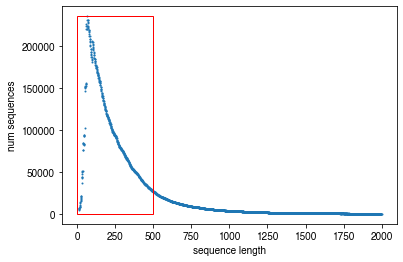

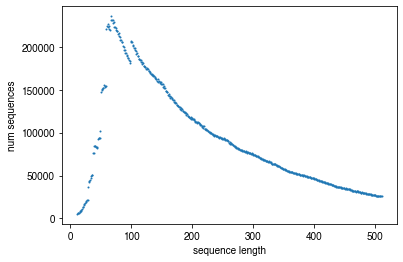

In [5]:
# what is the sequence length distribution in uniref50?

length_counts = uniref_sequences.apply(lambda x: len(x)).value_counts().sort_index()
window = 500

fig, ax = plt.subplots()
plt.scatter(x=length_counts.index, y=length_counts, s=1)
rect = patches.Rectangle(
    (window, 0),
    -window,
    length_counts.max(),
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
ax.add_patch(rect)
plt.xlabel("sequence length")
plt.ylabel("num sequences")

length_counts
fig, ax = plt.subplots()
plt.scatter(x=length_counts.index[:window], y=length_counts[:window], s=1)
plt.xlabel("sequence length")
plt.ylabel("num sequences")

In [6]:
# load malid seqs
malid_sequences = load_sequences_from_fold(
    fold_id=1, fold_label="test", gene_locus=GeneLocus.BCR
)

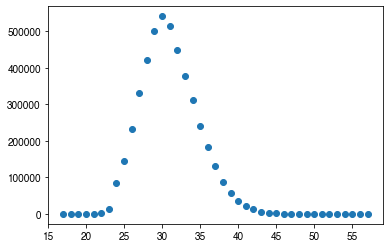

In [7]:
# what is the distribution of sequence lengths in the malid data?
length_counts = (
    pd.Series(malid_sequences).apply(lambda x: len(x)).value_counts().sort_index()
)
plt.scatter(length_counts.index, length_counts)

In [8]:
# load jax unirep with standard configuration
base_params = load_params()


def fetch_malid_fold_data(gene_locus, fold_id, downsample=None):
    """
    For a given fold, load the parameters of the model as well as the sequence data for train/test/val splits
    Optionally downsample the reads
    """
    best_params = joblib.load(
        config.paths.fine_tuned_embedding_dir
        / f"{gene_locus.name}/fold_{fold_id}/best_params.joblib"
    )
    test_sequences = load_sequences_from_fold(
        fold_id=fold_id, fold_label="test", gene_locus=gene_locus
    )
    val_sequences = load_sequences_from_fold(
        fold_id=fold_id, fold_label="validation", gene_locus=gene_locus
    )
    train_sequences = load_sequences_from_fold(
        fold_id=fold_id, fold_label="train_smaller", gene_locus=gene_locus
    )

    if downsample:
        test_sequences = np.random.choice(test_sequences, downsample)
        val_sequences = np.random.choice(val_sequences, downsample)
        train_sequences = np.random.choice(train_sequences, downsample)

    return best_params, test_sequences, val_sequences, train_sequences


def calc_loss(params, sequences):
    """
    For a set of parameters and a set of sequences, calculate the average loss
    Sequences must be the same length
    """
    x, y = input_output_pairs(sequences)
    loss = float(avg_loss([x], [y], params, mlstm1900_apply_fun))
    return [len(sequences[0]), len(sequences), loss]


def weighted_average_loss(params, sequences):
    """
    This function calculates the cross-entropy loss for a batch of protein sequences of arbitrary length,
    by batching togethger all sequences of the same length and passing them through the mLSTM.
    We want to calculate a single average for the sequences, so we take the weighted average of the
    per-length losses (weighted by number of sequences in a given length)
    """
    length_indexed_sequences = {}
    for seq in sequences:
        if len(seq) in length_indexed_sequences.keys():
            length_indexed_sequences[len(seq)].append(seq)
        else:
            length_indexed_sequences[len(seq)] = [seq]
    losses = [
        calc_loss(params, length_indexed_sequences[i])
        for i in sorted(length_indexed_sequences.keys())
    ]
    summary = pd.DataFrame(losses, columns=["length", "n", "avg_loss"])
    weighted_avg_loss = sum(summary["avg_loss"] * summary["n"]) / sum(summary["n"])
    return weighted_avg_loss


def perplexity(params, sequences):
    return np.exp(weighted_average_loss(sequences, params))

# Experiment 1: Explore all of the models from each cross validation fold
This takes approximately 2 days to run, so hidden behind a feature flag for now

In [9]:
downsample = 10000

if run_extra_analysis:
    # keep uniref set consistent throughout analysis
    uniref_sample = np.random.choice(uniref_sequences, downsample)

    results = {}
    for gene_locus in config.gene_loci_used:
        for fold_id in config.cross_validation_fold_ids:
            (
                best_params,
                test_sequences,
                val_sequences,
                train_sequences,
            ) = fetch_malid_fold_data(gene_locus, fold_id, downsample)
            results[
                (gene_locus.name, fold_id, "finetune_test")
            ] = weighted_average_loss(best_params, test_sequences)
            results[(gene_locus.name, fold_id, "finetune_val")] = weighted_average_loss(
                best_params, val_sequences
            )
            results[
                (gene_locus.name, fold_id, "finetune_train")
            ] = weighted_average_loss(best_params, train_sequences)
            results[
                (gene_locus.name, fold_id, "finetune_uniref")
            ] = weighted_average_loss(best_params, uniref_sample)
            results[(gene_locus.name, fold_id, "base_test")] = weighted_average_loss(
                base_params, test_sequences
            )
            results[(gene_locus.name, fold_id, "base_val")] = weighted_average_loss(
                base_params, val_sequences
            )
            results[(gene_locus.name, fold_id, "base_train")] = weighted_average_loss(
                base_params, train_sequences
            )
            results[(gene_locus.name, fold_id, "base_uniref")] = weighted_average_loss(
                base_params, uniref_sample
            )

In [10]:
if run_extra_analysis:
    summary = (
        pd.Series(results)
        .reset_index()
        .rename(
            columns={
                "level_0": "gene_locus",
                "level_1": "fold",
                "level_2": "experiment",
                0: "loss",
            }
        )
    )
    summary["perplexity"] = np.exp(summary["loss"])
    summary.to_csv(
        config.paths.fine_tuned_embedding_dir / "cross_validation_loss_analysis.csv"
    )
    summary["model"] = summary["experiment"].apply(lambda x: x.split("_")[0])
    summary["dataset"] = summary["experiment"].apply(lambda x: x.split("_")[1])
    display(summary.drop("experiment", axis=1))
    display(
        summary.groupby(["gene_locus", "experiment"]).agg(
            {"loss": "mean", "perplexity": "mean"}
        )
    )

In [11]:
if run_extra_analysis:
    plt.figure()
    sns.stripplot(x="loss", y="experiment", hue="gene_locus", data=summary)
    plt.figure()
    sns.stripplot(
        y="perplexity",
        x="model",
        hue="dataset",
        data=summary,
        palette="Paired",
        order=["base", "finetune"],
    )
    plt.legend(bbox_to_anchor=(1, 1))

    plt.figure()
    sns.stripplot(
        y="loss",
        x="model",
        hue="dataset",
        data=summary,
        palette="Paired",
        order=["base", "finetune"],
    )
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel("cross entropy loss")

    plt.figure()
    sns.stripplot(
        y="loss",
        x="model",
        hue="gene_locus",
        data=summary,
        palette="Paired",
        order=["base", "finetune"],
    )
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel("cross entropy loss")

# Experiment 2: Only use -1 fold model
- Use validation set of sequences from the -1 fold model
- Add 20 bootstrap samples of 1000 sequences
- Make figure with confidence intervals

In [12]:
results = {}
for gene_locus in config.gene_loci_used:
    val_sequences = load_sequences_from_fold(
        fold_id=-1, fold_label="validation", gene_locus=gene_locus
    )
    best_params = joblib.load(
        config.paths.fine_tuned_embedding_dir
        / f"{gene_locus.name}/fold_-1/best_params.joblib",
    )
    for i in range(20):
        print(i)
        val_sample = np.random.choice(val_sequences, 1000)
        uniref_sample = np.random.choice(uniref_sequences, 1000)
        results[(gene_locus.name, i, "best", "validation")] = weighted_average_loss(
            best_params, val_sample
        )
        results[(gene_locus.name, i, "best", "uniref")] = weighted_average_loss(
            best_params, uniref_sample
        )
        results[(gene_locus.name, i, "base", "validation")] = weighted_average_loss(
            base_params, val_sample
        )
        results[(gene_locus.name, i, "base", "uniref")] = weighted_average_loss(
            base_params, uniref_sample
        )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [13]:
bootstraps = (
    pd.Series(results)
    .reset_index()
    .rename(
        columns={
            "level_0": "locus",
            "level_1": "iteration",
            "level_2": "model",
            "level_3": "dataset",
            0: "cross_val_entropy",
        }
    )
)

# perplexity = 2^{cross entropy loss}
bootstraps["perplexity"] = np.exp2(bootstraps["cross_val_entropy"])

bootstraps["model"] = bootstraps["model"].map(
    {"best": "Fine-tuned UniRep", "base": "Base UniRep"}
)
bootstraps.loc[
    (bootstraps["locus"] == "BCR") & (bootstraps["dataset"] == "validation"), "Dataset"
] = "BCR sequences"
bootstraps.loc[
    (bootstraps["locus"] == "TCR") & (bootstraps["dataset"] == "validation"), "Dataset"
] = "TCR sequences"
bootstraps.loc[bootstraps["dataset"] == "uniref", "Dataset"] = "Uniref50 sequences"

In [14]:
bootstraps.to_csv(
    config.paths.output_dir / f"fine_tuning.catastrophic_forgetting_analysis.csv"
)

In [15]:
# We can resume from here by reloading from disk
bootstraps = pd.read_csv(
    config.paths.output_dir / f"fine_tuning.catastrophic_forgetting_analysis.csv",
    index_col=0,
)
bootstraps

,locus,iteration,model,dataset,cross_val_entropy,perplexity,Dataset
0,BCR,0,Fine-tuned UniRep,validation,0.110946,1.079936,BCR sequences
1,BCR,0,Fine-tuned UniRep,uniref,0.191261,1.141761,Uniref50 sequences
2,BCR,0,Base UniRep,validation,0.206802,1.154127,BCR sequences
3,BCR,0,Base UniRep,uniref,0.235150,1.177029,Uniref50 sequences
4,BCR,1,Fine-tuned UniRep,validation,0.110718,1.079765,BCR sequences
...,...,...,...,...,...,...,...
155,TCR,18,Base UniRep,uniref,0.235633,1.177423,Uniref50 sequences
156,TCR,19,Fine-tuned UniRep,validation,0.094989,1.068057,TCR sequences
157,TCR,19,Fine-tuned UniRep,uniref,0.212250,1.158493,Uniref50 sequences
158,TCR,19,Base UniRep,validation,0.212736,1.158884,TCR sequences


In [16]:
bootstraps.groupby(["locus", "model", "dataset"]).agg("mean")

iteration  cross_val_entropy  perplexity
locus model             dataset                                             
BCR   Base UniRep       uniref            9.5           0.236321    1.177985
                        validation        9.5           0.206557    1.153931
      Fine-tuned UniRep uniref            9.5           0.191727    1.142130
                        validation        9.5           0.111241    1.080157
TCR   Base UniRep       uniref            9.5           0.236402    1.178052
                        validation        9.5           0.212874    1.158995
      Fine-tuned UniRep uniref            9.5           0.212223    1.158472
                        validation        9.5           0.095037    1.068093

In [17]:
# borrow color mapping for disease color palette
colors = list(helpers.disease_color_palette.values())
color_mapping = dict(
    zip(
        bootstraps.Dataset.sort_values().unique(),
        colors[: bootstraps.Dataset.nunique()],
    )
)

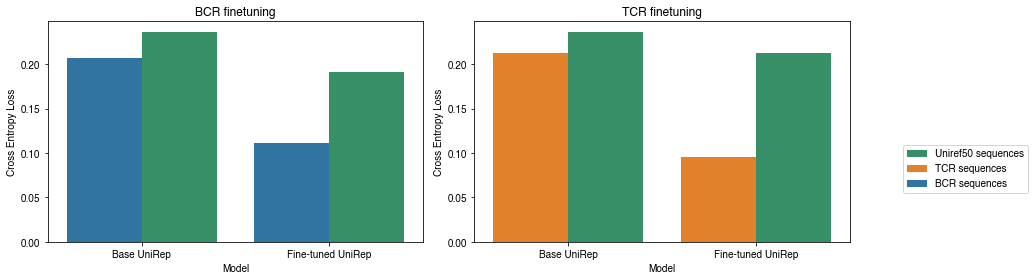

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))


sns.barplot(
    x="model",
    y="cross_val_entropy",
    hue="Dataset",
    order=["Base UniRep", "Fine-tuned UniRep"],
    hue_order=["BCR sequences", "Uniref50 sequences"],
    data=bootstraps.loc[bootstraps.locus == "BCR"],
    palette=[color_mapping[i] for i in ["BCR sequences", "Uniref50 sequences"]],
    ax=ax[0],
    ci=None,
)
ax[0].set_ylabel("Cross Entropy Loss")
ax[0].set_xlabel("Model")
ax[0].set_title("BCR finetuning")
ax[0].get_legend().remove()

sns.barplot(
    x="model",
    y="cross_val_entropy",
    hue="Dataset",
    order=["Base UniRep", "Fine-tuned UniRep"],
    hue_order=["TCR sequences", "Uniref50 sequences"],
    data=bootstraps.loc[bootstraps.locus == "TCR"],
    palette=[color_mapping[i] for i in ["TCR sequences", "Uniref50 sequences"]],
    ax=ax[1],
    ci=None,
)
ax[1].set_ylabel("Cross Entropy Loss")
ax[1].set_xlabel("Model")
ax[1].set_title("TCR finetuning")
ax[1].get_legend().remove()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
indexes = [labels.index(x) for x in set(labels)]
labels = [labels[i] for i in indexes]
lines = [lines[i] for i in indexes]

fig.legend(lines, labels, bbox_to_anchor=(1.2, 0.5))

fig.tight_layout()
genetools.plots.savefig(
    fig,
    config.paths.output_dir
    / f"fine_tuning.catastrophic_forgetting_analysis_cross_entropy_loss.png",
    dpi=300,
)

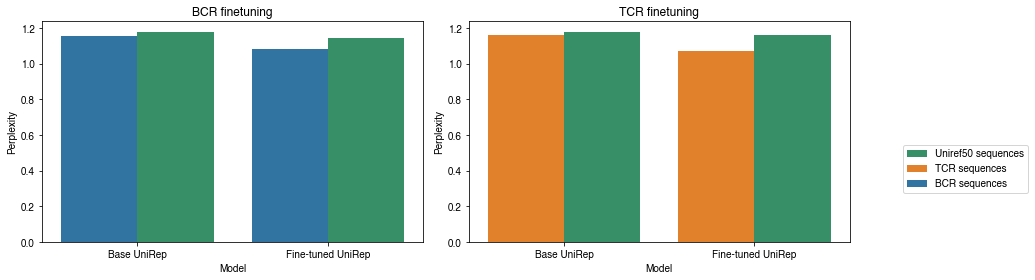

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(
    x="model",
    y="perplexity",
    hue="Dataset",
    order=["Base UniRep", "Fine-tuned UniRep"],
    hue_order=["BCR sequences", "Uniref50 sequences"],
    data=bootstraps.loc[bootstraps.locus == "BCR"],
    palette=[color_mapping[i] for i in ["BCR sequences", "Uniref50 sequences"]],
    ax=ax[0],
    ci=None,
)
ax[0].set_ylabel("Perplexity")
ax[0].set_xlabel("Model")
ax[0].set_title("BCR finetuning")
ax[0].get_legend().remove()

sns.barplot(
    x="model",
    y="perplexity",
    hue="Dataset",
    order=["Base UniRep", "Fine-tuned UniRep"],
    hue_order=["TCR sequences", "Uniref50 sequences"],
    data=bootstraps.loc[bootstraps.locus == "TCR"],
    palette=[color_mapping[i] for i in ["TCR sequences", "Uniref50 sequences"]],
    ax=ax[1],
    ci=None,
)
ax[1].set_ylabel("Perplexity")
ax[1].set_xlabel("Model")
ax[1].set_title("TCR finetuning")
ax[1].get_legend().remove()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
indexes = [labels.index(x) for x in set(labels)]
labels = [labels[i] for i in indexes]
lines = [lines[i] for i in indexes]

fig.legend(lines, labels, bbox_to_anchor=(1.2, 0.5))

fig.tight_layout()
genetools.plots.savefig(
    fig,
    config.paths.output_dir
    / f"fine_tuning.catastrophic_forgetting_analysis_perplexity.png",
    dpi=300,
)